# Scratchpad

A test field for larger implementations, sectioned when appropriate.

In [1]:
import imageio
import math
import numpy as np

## Measurement tests

In [2]:
import math
def i_RMSE(stitched, original):
    total_px = len(stitched) * len(original)
    stitched = stitched.astype('float64') / (100)
    original = original.astype('float64') / (100)
    abs_err = abs(original - stitched) ** 2
    print(abs_err)
    return math.sqrt((1/total_px) * abs_err.sum())


In [3]:
import numpy as np
x = np.array([45,67,21,89,33,56])
y = np.array([23,41,45,22,67,99])

i_RMSE(x,y)

[0.0484 0.0676 0.0576 0.4489 0.1156 0.1849]


0.16012148165967266

In [4]:
def fill_fn(fn, size):
    name = fn.__name__
    if name == 'NCC':
        return np.zeros(size)
    elif name == 'SSD' or name == 'SAD' or name == 'SRD':
        return np.full(size, np.inf)

def convolve(im, template, op):
    h_len, w_len = im.shape
    th, tw = template.shape
    op_res = fill_fn(op, (h_len-1, w_len-1))
    for i in range(h_len-th+1):
        for j in range(w_len-tw+1):
            op_res[i,j] = op(im[i:i+th, j:j+tw], template)
    return np.array(op_res)

def NCC(i1, i2):
    '''
    Normalized cross correlation, maximize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    f_err = i1 - i1.mean()
    t_err = i2 - i2.mean()
    nom = (f_err * t_err).sum()
    dnom = np.square(t_err).sum() * np.square(f_err).sum()
    if math.sqrt(dnom) == 0:
        return 0
    return nom / math.sqrt(dnom)

def SSD(i1, i2):
    '''
    Sum squared differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    sum_square = np.square(i2 - i1).sum() # (A - B)^2 
    return sum_square

def SAD(i1, i2):
    '''
    sum absolute differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    sum_absolute = (abs(i2 - i1)).sum() # | A - B | 
    return sum_absolute

def SRD(i1, i2):
    '''
    sum robust differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes "%s" v "%s"' % (i1.shape, i2.shape,)
    f = np.vectorize(huber_p)
    return f(i2-i1).sum()

def huber_p(u):
    c = 2**14
    if abs(u) <= c:
        return 0.5 * (u*u)
    # |u| > c
    return 0.5 * c * (2 * abs(u) - c)

In [5]:
x = np.array([[1,2],[3,4]])
x2 = np.pad(x, ((2,2),(3,2)), 'constant', constant_values=(0,0))

corr = convolve(x2, x, SSD)
_y, _x = np.unravel_index(np.argmin(corr), corr.shape)  # find the match
_y, _x

(2, 3)

In [6]:
corr

array([[30., 30., 30., 30., 30., 30.],
       [30., 30., 23., 13., 22., 30.],
       [30., 30., 12.,  0., 22., 30.],
       [30., 30., 27., 33., 38., 30.],
       [30., 30., 30., 30., 30., 30.]])

In [7]:
corr = convolve(x2, x, NCC)
_y, _x = np.unravel_index(np.argmax(corr), corr.shape)  # find the match
_y, _x

(2, 3)

In [8]:
corr

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.77459667,  0.94387981,  0.25819889,
         0.        ],
       [ 0.        ,  0.        ,  0.73029674,  1.        , -0.13483997,
         0.        ],
       [ 0.        ,  0.        , -0.25819889, -0.81409158, -0.77459667,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [9]:
corr = convolve(x2, x, SRD)
_y, _x = np.unravel_index(np.argmin(corr), corr.shape)  # find the match
_y, _x

(2, 3)

In [10]:
corr

array([[15. , 15. , 15. , 15. , 15. , 15. ],
       [15. , 15. , 11.5,  6.5, 11. , 15. ],
       [15. , 15. ,  6. ,  0. , 11. , 15. ],
       [15. , 15. , 13.5, 16.5, 19. , 15. ],
       [15. , 15. , 15. , 15. , 15. , 15. ]])

## Rotation tests

In [11]:
from PIL import Image
from scipy import ndimage
import imutils

import matplotlib.pyplot as plt

def plot_im(im):
    plt.imshow(im)
    plt.show()

ns_ref = (128,128)
ref_src = Image.open('../data/T1_Img_002.00.tif')
ref = np.array(ref_src.copy()).astype('uint16')#.resize(ns_ref)

plot_im(ref)

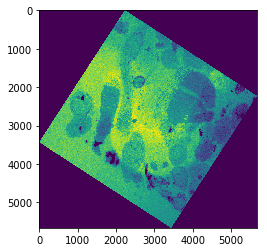

In [12]:
ref2 = imutils.rotate_bound(ref, 33)
plot_im(ref2)

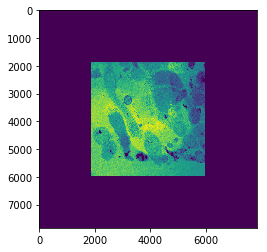

In [13]:
ref3 = imutils.rotate_bound(ref2, -33)
plot_im(ref3)

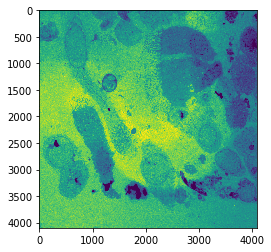

In [14]:
def crop_zeros(im, zero=0):
    # get the coordinates of every point > zero
    true_points = np.argwhere(im > zero)
    tl = true_points.min(axis=0) # top left corner
    br = true_points.max(axis=0) # bottom right corner
    out = im[tl[0]:br[0]+1,
             tl[1]:br[1]+1] 
    return out

plot_im(crop_zeros(ref3.copy(), zero=500))

In [15]:
def equalize_image(stitched, target_size):
    '''
    crop or pad stitched to a target size
    '''
    sh, sw = stitched.shape
    th, tw = target_size

    nh, nw = (0,0)
    if sw < tw:
        nw = tw - sw
    elif sw > tw:
        stitched = stitched[:,:tw]

    if sh < th:
        nh = th - sh
    elif sh > th:
        stitched = stitched[:th,:]

    if nw + nh > 0:
        return np.pad(stitched, ((0, nh), (0, nw)), 'constant', constant_values=(0,0))
    return stitched

In [16]:
x = np.array([[1,2,3], [4,5,6]])
y = np.array([[1,2], [4,5]])
assert equalize_image(x, y.shape).shape == (2,2), 'equalize_image cropped incorrectly'

y = np.array([[1,2,3], [4,5,6], [7,8,9]])
assert equalize_image(x, y.shape).shape == (3,3), 'equalize_image padded incorrectly'

y = np.array([[1,2], [4,5], [7,8]])
assert equalize_image(x, y.shape).shape == (3,2), 'equalize_image padded/cropped incorrectly'

y = np.array([[1,2,3,4], [4,5,6,7]])
assert equalize_image(x, y.shape).shape == (2,4), 'equalize_image padded/cropped incorrectly'

## Noise test

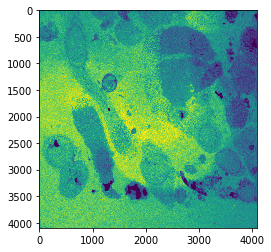

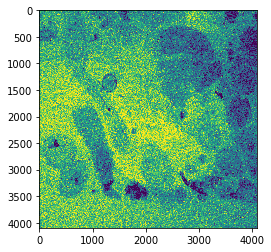

In [17]:
import skimage # noise

mean = 0
std = 0.02
noisy = skimage.util.random_noise(ref, mode='gaussian', mean=mean, var=std)
plot_im(ref)
plot_im(noisy)

## Fiducial markers tests

In [93]:
import math
class Point(object):
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
    def __iter__(self):
        yield self.x
        yield self.y
        
    def __repr__(self):
        return '(%f,%f)' % (self.x, self.y)

class Fiducial_corners(object):
    def __init__(self, shape, initial_transform=None):
        h,w = shape
        self.center = Point(w//2, h//2)
        self.corners = []
        self.corners.append(Point(0,0)) # tl
        self.corners.append(Point(w,0)) # tr
        self.corners.append(Point(w,h)) # br
        self.corners.append(Point(0,h)) # bl    
    
        self.reassign_pts()
        if initial_transform:
            self.transform(*initial_transform)
        
    def reassign_pts(self):
        self.tl = self.corners[0]
        self.tr = self.corners[1]
        self.br = self.corners[2]
        self.bl = self.corners[3]
    
    def min_x(self):
        return min(c.x for c in self.corners)
        
    def max_x(self):
        return max(c.x for c in self.corners)
    
    def min_y(self):
        return min(c.y for c in self.corners)
        
    def max_y(self):
        return max(c.y for c in self.corners)
    
    def transform(self, _x, _y, theta, unit='radians', temp_center=None):
        if unit[0] == 'd':
            theta = theta * math.pi/180
        if temp_center:
            cx,cy = temp_center
        else:
            cx,cy = self.center
        new_corners = []
        # rotate
        if theta != 0:
            min_x = np.inf
            min_y = np.inf
            for pt in self.corners:
                nx, ny = pt
                cos_t = math.cos(theta)
                sin_t = math.sin(theta)
                # temporary points
                tx = nx - cx
                ty = ny - cy
                # rotate
                nx = tx * cos_t - ty * sin_t
                ny = ty * cos_t + tx * sin_t
                # restore old center 
                nx += cx
                ny += cy
                new_corners.append(Point(nx,ny))
                min_x = min(nx, min_x)
                min_y = min(ny, min_y)
            # the points should not be less than 0
            if not temp_center:
                _x += -1 * min_x
                _y += -1 * min_y
            self.corners = new_corners
        # translate
        new_corners = []
        for pt in self.corners:
            nx = pt.x + _x
            ny = pt.y + _y
            new_corners.append(Point(nx,ny))
        self.center.x += _x
        self.center.y += _y
        self.corners = new_corners
        self.reassign_pts()
        return self

def transform_group(group, _x, _y, theta, temp_center=None, unit='radians'): 
    min_x = np.inf
    min_y = np.inf
    for f in group:
        f.transform(0, 0, theta, unit=unit, temp_center=temp_center)
        for c in f.corners:
            mx,my = c
            min_x = min(mx, min_x)
            min_y = min(my, min_y)
    min_x *= -1
    min_y *= -1
    for f in group:
        f.transform(_x+min_x, _y+min_y, 0)


[(128.000000,0.000000), (349.702503,128.000000), (221.702503,349.702503), (0.000000,221.702503)]


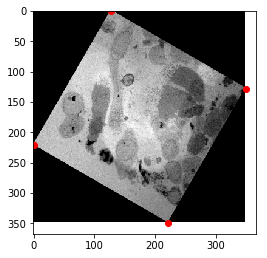

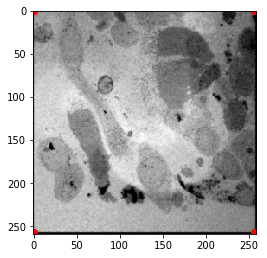

In [94]:
def showimfids(i, fids):
    fig, a = plt.subplots(1, 1, figsize=(4, 5))
    colors = ['ro', 'co', 'bo', 'yo']
    a.imshow(i, cmap='gray')
    for i,fid in enumerate(fids):
        for c in fid.corners:
            x,y = c
            a.plot(x,y, colors[i])
    plt.show()
    
ref = np.array(ref_src.copy().resize((256,256))).astype('uint16')
fids = Fiducial_corners(ref.shape)
theta = 30
x,y = (0,0)

ref = imutils.rotate_bound(ref, theta)
ref = np.pad(ref, ((y,0),(x,0)), mode='constant', constant_values=(0,0))

fids.transform(x, y, theta * math.pi/180)
print(fids.corners)
showimfids(ref, [fids])

old_shape = ref.shape
ref = imutils.rotate_bound(ref, -theta)
fids.transform(0, 0, -theta * math.pi/180)
showimfids(crop_zeros(ref), [fids])

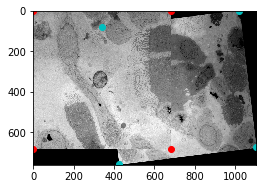

In [95]:
import imageio
from imutils import resize

gt_theta = 20 * math.pi / 180
x = 341
theta = -27

im1 = imageio.imread('../data/T1_segment_rot_1.tif')
ref_fids = Fiducial_corners(im1.shape)
im2 = imageio.imread('../data/T1_segment_rot_2.tif')
# use the base shape of the image, not the shape with rotation
mov_fids = Fiducial_corners(im1.shape, initial_transform=(0,0, gt_theta))

im2 = crop_zeros(imutils.rotate_bound(im2, theta))
im2 = np.pad(im2, ((0,0),(x,0)), 'constant', constant_values=(0,0))
mov_fids.transform(x, 0, theta, unit='d')

import sys
sys.path.insert(0, '../src')
from util import eq_paste

im3 = eq_paste(im1, im2)
showimfids(im3, [ref_fids, mov_fids])

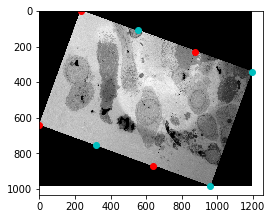

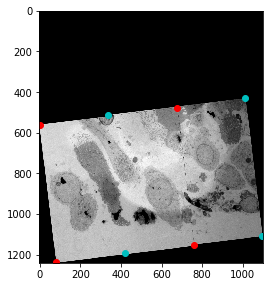

In [96]:
C = imageio.imread('../data/T1_segment_rot_3.tif')
C_fids = Fiducial_corners(im1.shape, initial_transform=(0,0,gt_theta))
D = imageio.imread('../data/T1_segment_rot_4.tif')
D_fids = Fiducial_corners(im1.shape, initial_transform=(0,0,gt_theta))

x = 320
y = 110
D = np.pad(D, ((y,0),(x,0)), 'constant', constant_values=(0,0))
D_fids.transform(x, y, 0, unit='d')
CD = eq_paste(C, D)
showimfids(CD, [C_fids, D_fids])

y = 430
CD = crop_zeros(imutils.rotate_bound(CD, theta))
CD = np.pad(CD, ((y,0),(0,0)), 'constant', constant_values=(0,0))
transform_group([C_fids, D_fids], 0, y, theta, unit='d', temp_center=Point(CD.shape[1]//2, CD.shape[0]//2))
showimfids(CD, [C_fids, D_fids])

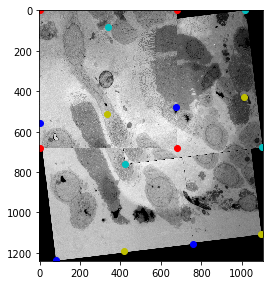

In [97]:
final = eq_paste(im3, CD)
showimfids(final, [ref_fids, mov_fids, C_fids, D_fids])

In [98]:
def dist(p1, p2):
    L = (p1.x - p2.x)**2 + (p1.y - p2.y)**2
    return math.sqrt(L)

def total_error(fids, expected):
    '''
    Fiducials fomatted A,B,C,D
    '''
    labels = ['A', 'B', 'C', 'D']
    g = dict(zip(labels, fids))
    ab1 = dist(g['A'].tr, g['B'].tl)
    ab2 = dist(g['A'].br, g['B'].bl)
    
    ac1 = dist(g['A'].bl, g['C'].tl)
    ac2 = dist(g['A'].br, g['C'].tr)
    
    cd1 = dist(g['C'].tr, g['D'].tl)
    cd2 = dist(g['C'].br, g['D'].bl)
    
    bd1 = dist(g['B'].bl, g['D'].tl)
    bd2 = dist(g['B'].br, g['D'].tr)
    return abs(sum([ab1, ab2, ac1, ac2, cd1, cd2, bd1, bd2]) - expected)

print(total_error([ref_fids, mov_fids, C_fids, D_fids], 1000))

print(mov_fids.max_x() - ref_fids.min_x(), final.shape)
print(C_fids.max_y() - ref_fids.min_x())

1159.260486847631
1101.0313676216922 (1240, 1104)
1237.2976098776267


In [101]:
f_copy = mov_fids.transform(0,0,45, unit='d')
f_copy, mov_fids

(<__main__.Fiducial_corners at 0x181d37d828>,
 <__main__.Fiducial_corners at 0x181d37d828>)